# Análisis Covid USA

## Bibliotecas

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sodapy import Socrata
import requests
from requests.structures import CaseInsensitiveDict
import csv
import io
from matplotlib import lines
from matplotlib import patches
from matplotlib.patheffects import withStroke
import plotly.offline as po
import plotly.graph_objs as pg

## Petición de datos
La petición de datos se realiza usando la API socrata

In [54]:
headers = CaseInsensitiveDict()
headers["Accept"] = "application/json"
headers['X-App-Token'] = 'IMOet43b8hwoSHaZuEUxhiEId'


url = 'https://healthdata.gov/resource/g62h-syeh.csv?$limit=48000'

data = requests.get(url, headers=headers)
data_df = pd.read_csv(io.StringIO(data.text), parse_dates=['date'])
data_df.sort_values('date', inplace=True)
data_df.reset_index(inplace=True, drop=True)
data_df = data_df[data_df['date'] <= '2022-08-01']
data_df

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage
0,MT,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1,TX,2020-01-01,0,0,3,0,0,3,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
2,PR,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
3,HI,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
4,IN,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47418,SD,2022-08-01,1,53,10,2,52,10,14.0,61,...,0.0,42,0.0,61,0.0,61,7.0,61,23.0,61
47419,IL,2022-08-01,4,155,28,14,148,25,21.0,182,...,2.0,162,0.0,182,4.0,182,358.0,182,589.0,182
47420,RI,2022-08-01,1,0,13,5,7,2,2.0,13,...,0.0,13,0.0,13,0.0,13,79.0,13,91.0,13
47421,MA,2022-08-01,0,4,79,22,60,1,29.0,82,...,1.0,82,0.0,82,6.0,82,151.0,82,166.0,82


## Resolución preguntas

### 1. ¿Cuáles fueron los 5 Estados con mayor ocupación hospitalaria por COVID? Criterio de ocupación por cama común. Considere la cantidad de camas ocupadas con pacientes confirmados y tome como referencia los 6 primeros meses del 2020 - recuerde incluir la cifra de infectados en esos meses (acumulativo). ¿Influye el rango etario en este comportamiento?

Se usó la documentación con el fin de identificar las columnas que aportan la información necesaria para resolver esta pregunta. Para calcular el número de casos positivos se sumó el total de pacientes adultos confirmados como positivos, los adultos internados en uci, los menores de edad confirmados como positivos y los menores de edad internados en uci

In [55]:
df = data_df.copy()
df = df[['state', 'date', 'inpatient_beds_used_covid',
'total_adult_patients_hospitalized_confirmed_covid',
'staffed_icu_adult_patients_confirmed_covid',
'total_pediatric_patients_hospitalized_confirmed_covid',
'staffed_icu_pediatric_patients_confirmed_covid']]

df.rename(columns={
    'inpatient_beds_used_covid': 'beds_covid',
    'total_adult_patients_hospitalized_confirmed_covid': 'adults_hospt',
    'staffed_icu_adult_patients_confirmed_covid': 'adults_uci',
    'total_pediatric_patients_hospitalized_confirmed_covid': 'children_hospt',
    'staffed_icu_pediatric_patients_confirmed_covid': 'children_uci'
}, inplace=True)

df.head()

,state,date,beds_covid,adults_hospt,adults_uci,children_hospt,children_uci
0,MT,2020-01-01,0.0,NaN,NaN,NaN,NaN
1,TX,2020-01-01,0.0,NaN,NaN,NaN,NaN
2,PR,2020-01-01,0.0,NaN,NaN,NaN,NaN
3,HI,2020-01-01,0.0,NaN,NaN,NaN,NaN
4,IN,2020-01-01,0.0,NaN,NaN,NaN,NaN


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47423 entries, 0 to 47422
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   state           47423 non-null  object        
 1   date            47423 non-null  datetime64[ns]
 2   beds_covid      47339 non-null  float64       
 3   adults_hospt    40902 non-null  float64       
 4   adults_uci      40457 non-null  float64       
 5   children_hospt  40224 non-null  float64       
 6   children_uci    17274 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.9+ MB


In [57]:
df.fillna(0, inplace=True)
df['total_cases'] = df.iloc[:, 3:7].sum(axis=1)
df.head()

,state,date,beds_covid,adults_hospt,adults_uci,children_hospt,children_uci,total_cases
0,MT,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0
1,TX,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0
2,PR,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0
3,HI,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0
4,IN,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
df.isna().sum()

state             0
date              0
beds_covid        0
adults_hospt      0
adults_uci        0
children_hospt    0
children_uci      0
total_cases       0
dtype: int64

In [59]:
df = df[df['date'] < '2020-07-01']
df['month_string'] = [d.strftime('%b') for d in df.date]
df_group = df.groupby('state')[['beds_covid','total_cases']].sum()
df_group.sort_values('beds_covid', ascending=False, inplace=True)
top_5 = df_group.head(5)
top_5

,beds_covid,total_cases
state,,
NY,686528.0,87.0
CA,434721.0,36134.0
FL,322227.0,0.0
TX,246237.0,0.0
IL,214010.0,0.0


Text(0, 0.5, 'Número Camas')

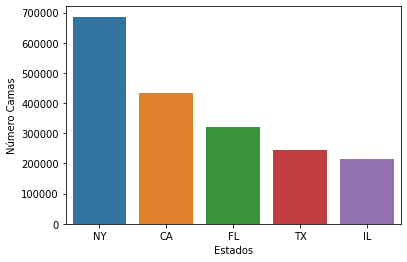

In [60]:
sns.barplot(x=top_5.index, y='beds_covid', data=top_5)
plt.xlabel('Estados')
plt.ylabel('Número Camas')

In [61]:
df = data_df.copy()
df = df[['state', 'date', 'inpatient_beds_used_covid',
'total_adult_patients_hospitalized_confirmed_covid',
'staffed_icu_adult_patients_confirmed_covid',
'total_pediatric_patients_hospitalized_confirmed_covid',
'staffed_icu_pediatric_patients_confirmed_covid']]

df.rename(columns={
    'inpatient_beds_used_covid': 'beds_covid',
    'total_adult_patients_hospitalized_confirmed_covid': 'adults_hospt',
    'staffed_icu_adult_patients_confirmed_covid': 'adults_uci',
    'total_pediatric_patients_hospitalized_confirmed_covid': 'children_hospt',
    'staffed_icu_pediatric_patients_confirmed_covid': 'children_uci'
}, inplace=True)

df.fillna(0, inplace=True)
df['total_cases'] = df.iloc[:, 3:7].sum(axis=1)

df = df[df['date'] < '2020-07-01']
df['month_string'] = [d.strftime('%b') for d in df.date]
df_group = df.groupby('state')[['beds_covid','total_cases']].sum()
df_group.sort_values('beds_covid', ascending=False, inplace=True)
top_5 = df_group.head(5).copy()
top_5['beds_covid'] = round(top_5['beds_covid'], 0)
top_5['states_full'] = ['Nueva York', 'California', 'Florida', 'Texas', 'Illinois']

top_5

,beds_covid,total_cases,states_full
state,,,
NY,686528.0,87.0,Nueva York
CA,434721.0,36134.0,California
FL,322227.0,0.0,Florida
TX,246237.0,0.0,Texas
IL,214010.0,0.0,Illinois


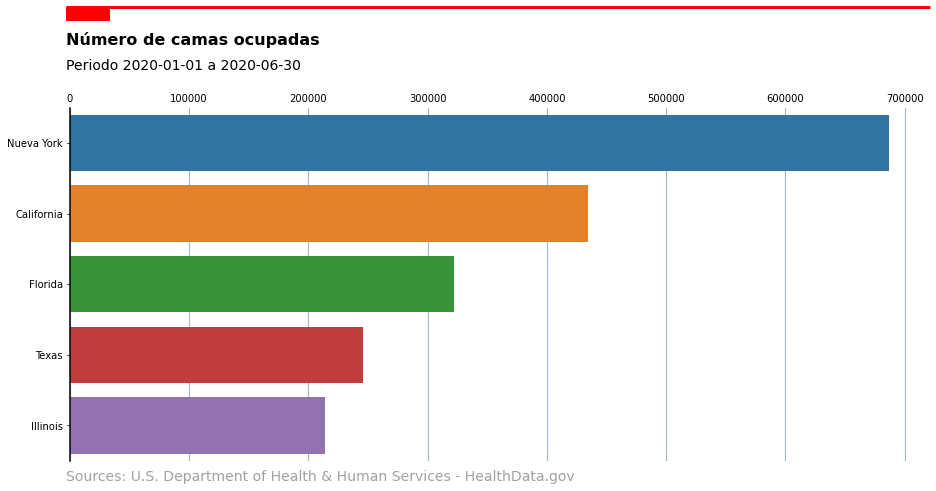

In [62]:
fig,ax = plt.subplots(figsize=(12, 7))
sns.barplot(x='beds_covid', y='states_full', data=top_5)

ax.set_axisbelow(True)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)
ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)

plt.ylabel('')
plt.xlabel('')

fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)
fig.text(
    0, 0.925, "Número de camas ocupadas", 
    fontsize=16, fontweight="bold"
)
fig.text(
    0, 0.875, "Periodo 2020-01-01 a 2020-06-30", 
    fontsize=14
)
source = "Sources: U.S. Department of Health & Human Services - HealthData.gov"
fig.text(
    0, 0.06, source, color="#a2a2a2", 
    fontsize=14, fontfamily="Econ Sans Cnd"
)
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='red', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='red'))

Los 5 estados con mayor ocupación de camas son New York, California, Florida, Texas e Illinois. No se usó la columna de rango etario, ya que mostraba información incompleta. Analizando los resultados encontrados, se observa grandes cantidades de usos de camas para, relativamente, pocos casos. Esto puede ser a que la información no está bien cargada, o las columnas usadas para realizar el cálculo del número de casos no aportaban la información correcta. Aun así se puede realizar un análisis, los estados con más camas ocupadas son cinco de los seis estados más poblados de Estados Unidos, también son estados que sufrieron brotes muy grandes al inicio de la pandemia, llegando a tener incluso problemas en la atención de pacientes con COVID-19

## 2. Analice la ocupación de camas (Común) por COVID en el Estado de Nueva York durante la cuarentena establecida e indique:

* Intervalos de crecimiento y decrecimiento
* Puntos críticos (mínimos y máximos)

El periodo a analizar se toma a partir de la declaratoria del gobernador del estado de Nueva York Andrew Cuomo de iniciar el programa "NYS on Pause" el 20 de Marzo de 2020 y que se extendió hasta el 8 de Junio de 2020

In [63]:
df_ny = data_df[((data_df['date'] >= '2020-03-20') & (data_df['date'] <= '2020-08-31'))]
df_ny = df_ny[df_ny['state'] == 'NY']
df_ny

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage
1323,NY,2020-03-20,0,0,4,0,0,4,0.0,3,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1364,NY,2020-03-21,0,0,4,0,0,4,0.0,3,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1411,NY,2020-03-22,0,0,4,0,0,4,0.0,3,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1446,NY,2020-03-23,0,0,4,0,0,4,0.0,3,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1505,NY,2020-03-24,0,0,4,0,0,4,0.0,3,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,NY,2020-08-27,8,113,46,7,113,47,23.0,131,...,NaN,0,NaN,0,3.0,121,703.0,118,898.0,112
9786,NY,2020-08-28,8,115,45,7,115,46,17.0,132,...,NaN,0,NaN,0,3.0,122,721.0,118,900.0,114
9833,NY,2020-08-29,7,116,45,7,115,46,19.0,132,...,NaN,0,NaN,0,3.0,122,689.0,118,903.0,114
9920,NY,2020-08-30,7,117,44,7,116,45,24.0,132,...,NaN,0,NaN,0,2.0,123,696.0,118,900.0,112


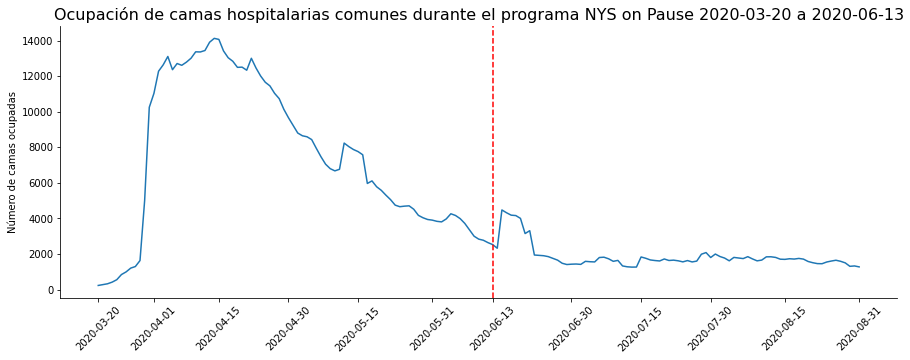

In [64]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='inpatient_beds_used_covid', data=df_ny)

plt.axvline(pd.to_datetime('2020-06-13'), color='red', ls='--')

ticks = [pd.to_datetime('2020-03-20'), pd.to_datetime('2020-04-01'), pd.to_datetime('2020-04-15'),
         pd.to_datetime('2020-04-30'), pd.to_datetime('2020-05-15'), pd.to_datetime('2020-05-31'),
         pd.to_datetime('2020-06-13'), pd.to_datetime('2020-06-30'), pd.to_datetime('2020-07-15'), 
         pd.to_datetime('2020-07-30'), pd.to_datetime('2020-08-15'), pd.to_datetime('2020-08-31')]

plt.xticks(ticks, rotation=45)

plt.xlabel('')
plt.ylabel('Número de camas ocupadas')
plt.title('Ocupación de camas hospitalarias comunes durante el programa NYS on Pause 2020-03-20 a 2020-06-13',
          fontsize=16)
sns.despine(left=False, bottom=False)

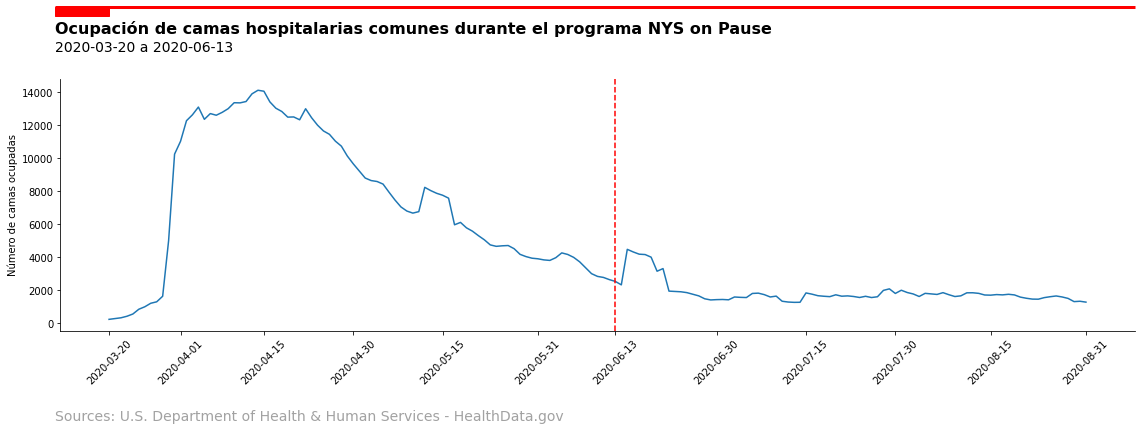

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x='date', y='inpatient_beds_used_covid', data=df_ny)

plt.axvline(pd.to_datetime('2020-06-13'), color='red', ls='--')

ticks = [pd.to_datetime('2020-03-20'), pd.to_datetime('2020-04-01'), pd.to_datetime('2020-04-15'),
         pd.to_datetime('2020-04-30'), pd.to_datetime('2020-05-15'), pd.to_datetime('2020-05-31'),
         pd.to_datetime('2020-06-13'), pd.to_datetime('2020-06-30'), pd.to_datetime('2020-07-15'), 
         pd.to_datetime('2020-07-30'), pd.to_datetime('2020-08-15'), pd.to_datetime('2020-08-31')]

plt.xticks(ticks, rotation=45)

plt.xlabel('')
plt.ylabel('Número de camas ocupadas')
sns.despine(left=False, bottom=False)

fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)
fig.text(
    0, 0.925, "Ocupación de camas hospitalarias comunes durante el programa NYS on Pause",
    fontsize=16, fontweight="bold"
)
fig.text(
    0, 0.875, "2020-03-20 a 2020-06-13", 
    fontsize=14
)
source = "Sources: U.S. Department of Health & Human Services - HealthData.gov"
fig.text(
    0, -0.15, source, color="#a2a2a2", 
    fontsize=14, fontfamily="Econ Sans Cnd"
)
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='red', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='red'))

Al iniciar el periodo de cuarentena se viene con un crecimiento lineal en el número de hospitalizaciones, finalizando el mes de marzo, se inicia un periodo de crecimiento exponencial llegando a un primer pico de 10000 camas ocupadas. Este pico sigue incrementando hasta llegar a casi 13000 camas. Hacia el 15 de Abril se tiene el pico absoluto de camas ocupadas rozando las 14000. A partir de los días posteriores se ve un decrecimiento general con picos en algunos momentos, el primero hacia el 20 de Abril y el segundo hacia el 15 de mayo coincidiendo con la autorización de reuniones de más de 10 personas. La línea punteada muestra la fecha del fin del programa, se agregó dos meses más de información para realizar una comparación con el programa, encontrando de esta manera, un pico justo al finalizar el programa, que se debe a la reapertura del estado y su economía, sin embargo este pico no dura más de dos semanas y el decrecimiento en la ocupación hospitalaria decrece constantemente y casi que se estabiliza en aproximadamente 3500 camas. Algo adicional que se puede mencionar es el aplanamiento de la curva, tal como se ve en el gráfico se pasó de un pico epidémico a una curva aplana en la que van a haber pequeños picos a futuro.

## 3. ¿Cuáles fueron los cinco Estados que más camas UCI -Unidades de Cuidados Intensivos- utilizaron durante el año 2020? La medición debe realizarse en términos absolutos.

In [66]:
df = data_df[data_df['date'] < '2021-01-01']
df

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage
0,MT,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1,TX,2020-01-01,0,0,3,0,0,3,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
2,PR,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
3,HI,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
4,IN,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16441,NV,2020-12-31,20,41,2,23,38,2,45.0,61,...,NaN,0,NaN,0,NaN,0,0.0,5,0.0,5
16442,SD,2020-12-31,1,61,3,2,60,3,46.0,62,...,NaN,0,NaN,0,NaN,0,30.0,62,83.0,62
16443,AR,2020-12-31,18,92,2,21,89,2,14.0,110,...,NaN,0,NaN,0,NaN,0,238.0,110,415.0,110
16444,LA,2020-12-31,47,166,8,50,163,8,14.0,213,...,NaN,0,NaN,0,NaN,0,4.0,4,11.0,4


In [67]:
df = df[['state', 'staffed_icu_adult_patients_confirmed_covid']]
df_group = df.groupby('state').sum()
df_group.sort_values('staffed_icu_adult_patients_confirmed_covid', ascending=False, inplace=True)
camas_icu = df_group.head(5).copy()
camas_icu['states_full'] = ['Texas', 'California', 'Florida', 'Georgia', 'Ohio']
camas_icu

,staffed_icu_adult_patients_confirmed_covid,states_full
state,,
TX,335836.0,Texas
CA,260865.0,California
FL,175859.0,Florida
GA,95596.0,Georgia
OH,89483.0,Ohio


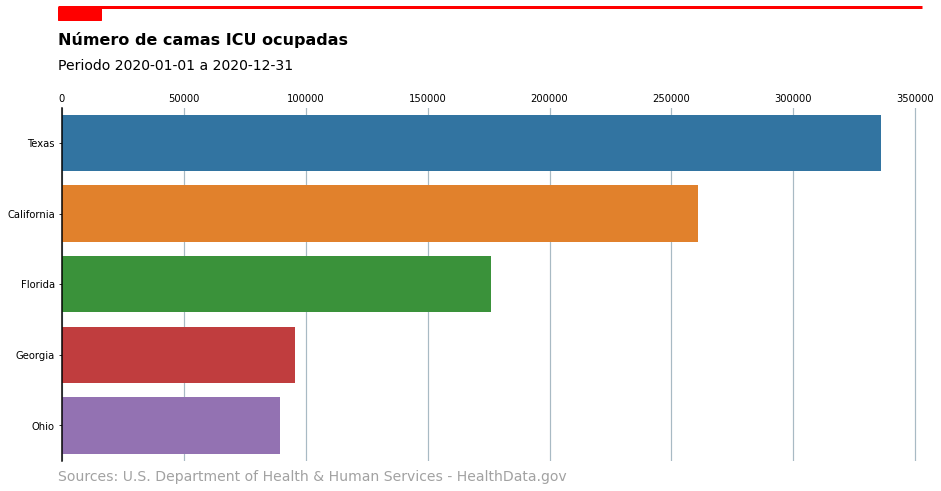

In [68]:
df = data_df[data_df['date'] < '2021-01-01']
df = df[['state', 'staffed_icu_adult_patients_confirmed_covid']]
df_group = df.groupby('state').sum()
df_group.sort_values('staffed_icu_adult_patients_confirmed_covid', ascending=False, inplace=True)
camas_icu = df_group.head(5).copy()
camas_icu['states_full'] = ['Texas', 'California', 'Florida', 'Georgia', 'Ohio']
fig,ax = plt.subplots(figsize=(12, 7))
sns.barplot(x='staffed_icu_adult_patients_confirmed_covid', y='states_full', data=camas_icu)

ax.set_axisbelow(True)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)
ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)

plt.ylabel('')
plt.xlabel('')

fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)
fig.text(
    0, 0.925, "Número de camas ICU ocupadas", 
    fontsize=16, fontweight="bold"
)
fig.text(
    0, 0.875, "Periodo 2020-01-01 a 2020-12-31", 
    fontsize=14
)
source = "Sources: U.S. Department of Health & Human Services - HealthData.gov"
fig.text(
    0, 0.06, source, color="#a2a2a2", 
    fontsize=14, fontfamily="Econ Sans Cnd"
)
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='red', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='red'))

Los estados de Texas, California, Florida, Georgia y Ohio son los estados con más ocupación de camas UCI en los estados unidos durante el año 2020. De estos 5, solo Texas, California y Florida aparecen en el top 5 con mayor ocupación hospitalaria. Se puede argumentar que Georgia y Ohio tuvieron que enfrentar casos más graves de covid durante el año en mención. También es interesante notar que Nueva York, que fue el estado que usó más camas comunes, no aparece en el top 5 de uso de camas de cuidado intensivo, así que se puede asumir que Nueva York tuvo menos casos graves y/o la atención dada en este estado a los pacientes con COVID-19 fue mejor evitando la admisión de pacientes en UCI

## 4. ¿Qué cantidad de camas se utilizaron, por Estado, para pacientes pediátricos con COVID durante el 2020?

In [69]:
df = data_df[data_df['date'] < '2021-01-01']
df

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage
0,MT,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1,TX,2020-01-01,0,0,3,0,0,3,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
2,PR,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
3,HI,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
4,IN,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16441,NV,2020-12-31,20,41,2,23,38,2,45.0,61,...,NaN,0,NaN,0,NaN,0,0.0,5,0.0,5
16442,SD,2020-12-31,1,61,3,2,60,3,46.0,62,...,NaN,0,NaN,0,NaN,0,30.0,62,83.0,62
16443,AR,2020-12-31,18,92,2,21,89,2,14.0,110,...,NaN,0,NaN,0,NaN,0,238.0,110,415.0,110
16444,LA,2020-12-31,47,166,8,50,163,8,14.0,213,...,NaN,0,NaN,0,NaN,0,4.0,4,11.0,4


In [70]:
df = df[['state', 'total_pediatric_patients_hospitalized_confirmed_covid']]
df_group = df.groupby('state').sum()
df_group.sort_values('total_pediatric_patients_hospitalized_confirmed_covid', ascending=False, inplace=True)
peds = df_group.head(5).copy()
peds['states_full'] = ['Texas', 'California', 'Florida', 'Arizona', 'Pensilvania']
peds

,total_pediatric_patients_hospitalized_confirmed_covid,states_full
state,,
TX,12525.0,Texas
CA,10012.0,California
FL,7239.0,Florida
AZ,5762.0,Arizona
PA,5686.0,Pensilvania


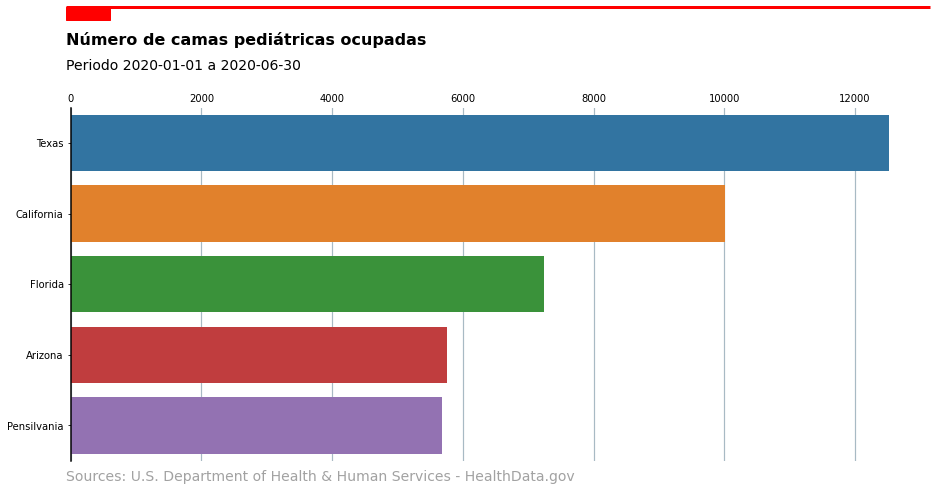

In [71]:
fig,ax = plt.subplots(figsize=(12, 7))
sns.barplot(x='total_pediatric_patients_hospitalized_confirmed_covid', y='states_full', data=peds)

ax.set_axisbelow(True)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)
ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)

plt.ylabel('')
plt.xlabel('')

fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)
fig.text(
    0, 0.925, "Número de camas pediátricas ocupadas", 
    fontsize=16, fontweight="bold"
)
fig.text(
    0, 0.875, "Periodo 2020-01-01 a 2020-06-30", 
    fontsize=14
)
source = "Sources: U.S. Department of Health & Human Services - HealthData.gov"
fig.text(
    0, 0.06, source, color="#a2a2a2", 
    fontsize=14, fontfamily="Econ Sans Cnd"
)
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='red', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='red'))

En el caso de camas pediátricas, Texas, California y Florida vuelven a aparecer, estos son los 3 estados más poblados de la comunidad americana. Los sigue Arizona y Pensilvania, que son el quinto y catorceavo estado en población respectivamente. Algo importante a decir es que la Academia Americana de pediatría, solo recopila datos de 49 estados de los Estados Unidos con respecto al covid, dentro de los cuales no se encuentra Texas, que solo reporta una pequeña porción de los casos relacionados con menores de edad, por lo que los casos en Texas pueden ser más de lo reportado. Así pues la información sobre la ocupación de camas de pediatría no es muy confiable. Sin embargo, es preocupante la cantidad de camas ocupadas por pacientes menores de edad.

## 5 - ¿Qué porcentaje de camas UCI corresponden a casos confirmados de COVID-19? Agrupe por Estado.

In [72]:
df = data_df[['state', 'total_staffed_adult_icu_beds', 'staffed_adult_icu_bed_occupancy']].copy()
df.rename(columns={
    'total_staffed_adult_icu_beds' : 'icu_beds_available',
    'staffed_adult_icu_bed_occupancy' : 'icu_beds_occupied'
}, inplace=True)
df_grouped = df.groupby('state').sum()
df_grouped['%_occupation'] = round((df_grouped['icu_beds_occupied'] / df_grouped['icu_beds_available']) * 100, 3)
df_grouped.sort_values('%_occupation', ascending=False, inplace=True)
df_grouped.head()

,icu_beds_available,icu_beds_occupied,%_occupation
state,,,
TX,5054130.0,4381263.0,86.687
AL,1169591.0,995509.0,85.116
RI,116703.0,96462.0,82.656
GA,1931468.0,1578410.0,81.721
NM,319348.0,259303.0,81.198


In [73]:
data_plot = {
    'type':'choropleth',
    'locations':df_grouped.index.values,
    'locationmode': 'USA-states',
    'z':df_grouped['%_occupation']
}

layout = {'title':'Porcentaje ocupación camas UCI desde Enero 2020 a hoy',
          'geo':{'scope':'usa'},
          'height': 600,
          'width': 900}

x = pg.Figure(data = [data_plot], layout=layout)
po.iplot(x)

Texas ocupa el primer lugar en el porcentaje de camas UCI ocupadas con un 87%, lo cual es interesante ya que como se ha mencionado anteriormente, Texas es el segundo estado con más población en los Estados Unidos. Alabama ocupa el segundo lugar con una ocupación del 85%. Rhode Island ocupa la tercera posición con un 83% de ocupación, le sigue Georgia y Nuevo México con un 82 y 81% respectivamente. Ninguno de estos estados estuvo en una cuarentena obligatoria. En comparación el estado de Wyoming, que tampoco tuvo cuarentena, es el estado con menor porcentaje de ocupación con apenas 41%. Esto se debe a que este estado es el que menos población tiene (sin tener en cuenta los territorios insulares de Estados Unidos en el Atlántico y Pacífico)

## 6 - ¿Cuántas muertes por covid hubo, por Estado, durante el año 2021?

In [74]:
df = data_df[(data_df['date'] >= '2021-01-01') & (data_df['date'] < '2022-01-01')].copy()
df = df[['state', 'deaths_covid']]
df_grouped = df.groupby('state').sum()
df_grouped.sort_values('deaths_covid', inplace=True, ascending=False)
df_grouped

,deaths_covid
state,
CA,35108.0
TX,32889.0
FL,26004.0
NY,17620.0
AZ,16250.0
PA,13363.0
GA,12338.0
OH,12023.0
NC,10922.0


In [75]:
df = data_df[(data_df['date'] >= '2021-01-01') & (data_df['date'] < '2022-01-01')].copy()
df = df[['state', 'deaths_covid']]
df_grouped = df.groupby('state').sum()
df_grouped.sort_values('deaths_covid', inplace=True, ascending=False)
data_plot = {
    'type':'choropleth',
    'locations':df_grouped.index.values,
    'locationmode': 'USA-states',
    'z':df_grouped['deaths_covid']
}

layout = {'title':'Muertes por estado desde Enero 2020 a hoy',
          'geo':{'scope':'usa'},
          'height': 600,
          'width': 900}

x = pg.Figure(data = [data_plot], layout=layout)
po.iplot(x)

Por tendencia los estados con mayor población ocupan los primeros lugares en la cantidad de muertes por COVID-19. El caso más interesante es de Arizona que ocupa el 14vo lugar en población, pero el quinto en número de fallecimientos. Este estado no tuvo una cuarentena obligatoria y tampoco ha tenido exito en su plan de vacunación debido a la resistencia de las personas por razones politicas y religiosas.

## 7 - ¿Qué relación presenta la falta de personal médico, con la cantidad de muertes por covid durante el año 2021? 

In [76]:
df = data_df[(data_df['date'] >= '2021-01-01') & (data_df['date'] < '2022-01-01')].copy()
df = df[['state', 'deaths_covid', 'critical_staffing_shortage_today_yes']]
df_grouped = df.groupby('state').sum()
df_grouped.sort_values('deaths_covid', inplace=True, ascending=False)
df_grouped

,deaths_covid,critical_staffing_shortage_today_yes
state,,
CA,35108.0,35082
TX,32889.0,27164
FL,26004.0,7993
NY,17620.0,2643
AZ,16250.0,10783
PA,13363.0,9160
GA,12338.0,12194
OH,12023.0,7330
NC,10922.0,2213


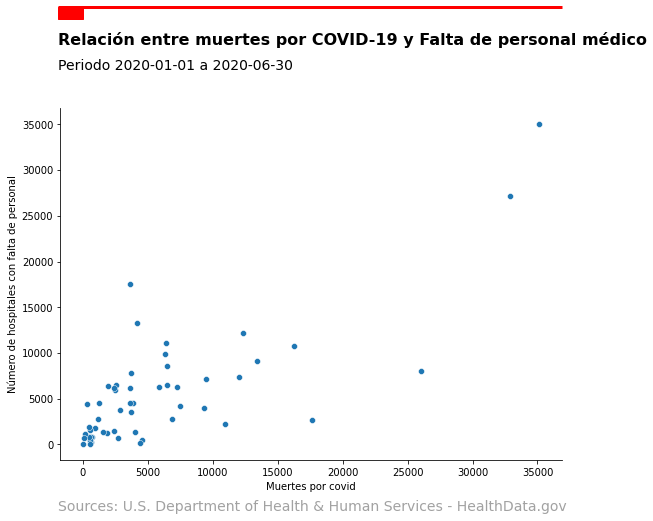

In [77]:
x = df_grouped['deaths_covid']
y = df_grouped['critical_staffing_shortage_today_yes']

fig,ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x=x, y=y, data=df_grouped)
ax.set_xlabel('Muertes por covid')
ax.set_ylabel('Número de hospitales con falta de personal')

fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)
fig.text(
    0, 0.925, "Relación entre muertes por COVID-19 y Falta de personal médico", 
    fontsize=16, fontweight="bold"
)
fig.text(
    0, 0.875, "Periodo 2020-01-01 a 2020-06-30", 
    fontsize=14
)
source = "Sources: U.S. Department of Health & Human Services - HealthData.gov"
fig.text(
    0, 0, source, color="#a2a2a2", 
    fontsize=14, fontfamily="Econ Sans Cnd"
)
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='red', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='red'))
sns.despine(left=False, bottom=False)

Para revisar la relación entre muertes por covid y la falta de personal médico se realizó un diagrama de dispersión. Si bien no se encontró una relación lineal, se puede observar que en ciertas cantidades de muertes hubo un número similar o cercano de hospitales con falta de personal. Y logicamente la falta de personal puede conllevar a que se deba cerrar unidades de cuidado intensivo, priorizar atención a ciertos pacientes o incluso negar la atención de pacientes con casos graves.

## 8 - Siguiendo las respuestas anteriores, ¿cuál fue el peor mes de la pandemia para USA en su conjunto? Puede utilizar otras medidas que considere necesarias.

In [78]:
df = data_df[['date', 'state', 'deaths_covid', 
         'critical_staffing_shortage_today_yes', 
         'staffed_adult_icu_bed_occupancy', 
         'total_adult_patients_hospitalized_confirmed_covid',
         ]].copy()

df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = df['date'].dt.isocalendar().year

df_grouped = df.groupby(['year', 'month']).sum()
df_grouped.sort_values(['deaths_covid'], inplace=True, ascending=False)
df_grouped.reset_index(inplace=True)
df_grouped

,year,month,deaths_covid,critical_staffing_shortage_today_yes,staffed_adult_icu_bed_occupancy,total_adult_patients_hospitalized_confirmed_covid
0,2021,1,62030.0,30833,2102367.0,3433622.0
1,2020,12,56674.0,37456,2111959.0,3377012.0
2,2020,5,54884.0,6,0.0,24939.0
3,2021,9,44903.0,29035,2047394.0,2555691.0
4,2022,1,39927.0,26195,1946551.0,3940530.0
5,2021,2,33733.0,22916,1818747.0,1811779.0
6,2020,4,33572.0,30,1705.0,56186.0
7,2020,11,33444.0,32528,1912448.0,2096196.0
8,2021,12,32541.0,31424,1981755.0,1982693.0
9,2021,8,32171.0,23797,2034597.0,2446087.0


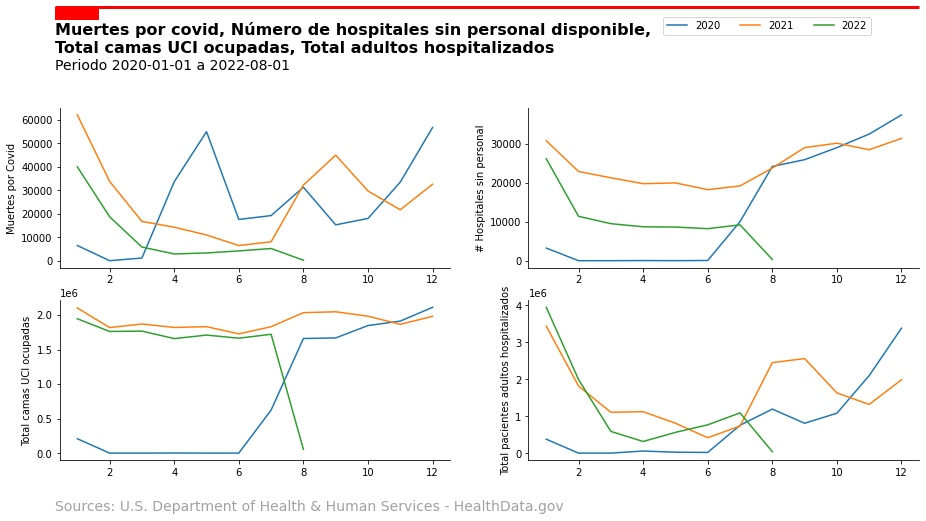

In [79]:
fig,ax = plt.subplots(2,2, figsize=(12, 7))
ax = ax.flatten()
df_grouped.year = pd.Categorical(df_grouped.year)
sns.lineplot(ax=ax[0], x='month', y='deaths_covid', data=df_grouped, hue='year')
sns.lineplot(ax=ax[1], x='month', y='critical_staffing_shortage_today_yes', data=df_grouped, hue='year')
sns.lineplot(ax=ax[2], x='month', y='staffed_adult_icu_bed_occupancy', data=df_grouped, hue='year')
sns.lineplot(ax=ax[3], x='month', y='total_adult_patients_hospitalized_confirmed_covid', data=df_grouped, hue='year')


ax[0].set_xlabel("")
ax[0].set_ylabel("Muertes por Covid")

ax[1].set_xlabel("")
ax[1].set_ylabel("# Hospitales sin personal")

ax[2].set_xlabel("")
ax[2].set_ylabel("Total camas UCI ocupadas")

ax[3].set_xlabel("")
ax[3].set_ylabel("Total pacientes adultos hospitalizados")

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc=1, bbox_to_anchor=(0.95,0.99), ncol=3, bbox_transform=fig.transFigure)
ax[1].legend([],[], frameon=False)
ax[2].legend([],[], frameon=False)
ax[3].legend([],[], frameon=False)

fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)
fig.text(
    0, 0.910, "Muertes por covid, Número de hospitales sin personal disponible, \nTotal camas UCI ocupadas, Total adultos hospitalizados", 
    fontsize=16, fontweight="bold"
)
fig.text(
    0, 0.875, "Periodo 2020-01-01 a 2022-08-01", 
    fontsize=14
)
source = "Sources: U.S. Department of Health & Human Services - HealthData.gov"
fig.text(
    0, 0, source, color="#a2a2a2", 
    fontsize=14, fontfamily="Econ Sans Cnd"
)
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='red', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='red'))
sns.despine(left=False, bottom=False)

Se graficó el número de muertes por covid, el número de hospitales sin personal disponible, el total de camas UCI ocupadas y el total de pacientes adultos hospitalizados para evaluar su desempeño durante los años que lleva la pandemia. Es interesante notar como todas las graficas incrementan hacia el final del año 2020. En el caso del total de camas ocupadas el año 2021 se mantuvo relativamente constante, disminuyendo un poco durante este año y luego ha tenido una caida dramatica, aunque se puede argumentar que no se debe estar reportando los datos desde Julio de este año para este item.
Algo en común que tienen las cuatro gráficas es que para el 2020 todas finalizan en picos y el 2021 inicia con dicho pico. A excepción del total de pacientes adultos hospitalizados cuyo mayor pico ocurre en enero de 2022. Pero aún así teninedo en cuenta esto, se puede argumentar que los peores meses de la pandemia son Diciembre y Enero de 2020 y 2021 respectivamante. Eso se debe a la falta de prevención de los ciudadanos durante las fiestas de navidad y año nuevo.

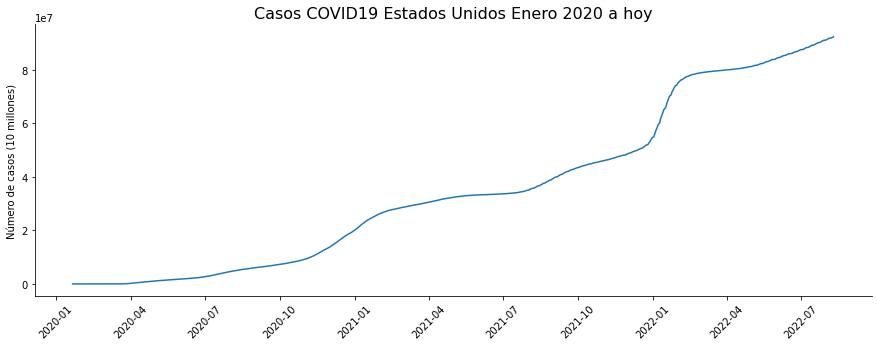

In [80]:
data_us = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv', parse_dates=['date'])
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='cases', data=data_us)

plt.xticks(rotation=45)

plt.xlabel('')
plt.ylabel('Número de casos (10 millones)')
plt.title('Casos COVID19 Estados Unidos Enero 2020 a hoy',
          fontsize=16)
sns.despine(left=False, bottom=False)

## Recomendaciones

Dejar a un lado la división politica

## Total hospitalizaciones en todo el dataset

In [94]:
df_test = data_df[['state', 'total_adult_patients_hospitalized_confirmed_covid', 'staffed_icu_adult_patients_confirmed_covid',
                          'total_pediatric_patients_hospitalized_confirmed_covid']].copy()
df_grouped = df_test.groupby('state').sum()
df_grouped['total_occupation'] = df_grouped[['total_adult_patients_hospitalized_confirmed_covid', 'staffed_icu_adult_patients_confirmed_covid',
                          'total_pediatric_patients_hospitalized_confirmed_covid']].sum(axis=1)
df_grouped.sort_values('total_occupation', ascending=False, inplace=True)
df_grouped.head()

,total_adult_patients_hospitalized_confirmed_covid,staffed_icu_adult_patients_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid,total_occupation
state,,,,
TX,4048445.0,1141077.0,85105.0,5274627.0
CA,3958334.0,896903.0,67577.0,4922814.0
FL,3292312.0,689918.0,46352.0,4028582.0
NY,2259035.0,396762.0,38714.0,2694511.0
PA,1608673.0,337956.0,29505.0,1976134.0


In [95]:
data_plot = {
    'type':'choropleth',
    'locations':df_grouped.index.values,
    'locationmode': 'USA-states',
    'z':df_grouped['total_occupation']
}

layout = {'title':'Total hospitalizados desde Enero 2020 a hoy',
        'geo':{'scope':'usa'},
        'height': 600,
        'width': 900}

x = pg.Figure(data = [data_plot], layout=layout)
po.iplot(x)

Los estados con mayor población son los estados con mayor cantidad de pacientes hospitalizados. Texas ocupa el primer lugar sobre California a pesar de ser el segundo estado más poblado de Estados Unidos, sin embargo, es uno si no el principal estado en oponerse a cualquier método de prevención de la COVID-19 debido a motivos políticos y religiosos. Ahora bien, atribuir la cantidad de pacientes hospitalizados a temas políticos y religiosos no es tan correcto cuando se evalúa el caso de California con por lo menos 300.000 hospitalizaciones menos. Este fue uno de los estados con casos más graves de ocupación hospitalaria en la que incluso se presentaron congestiones masivas en las zonas de descarga de pacientes en las salas de emergencias y esto a pesar de que este estado tuvo la cuarentena más larga del país, 453 días comprendidos entre el 19 de marzo del 2020 hasta el 15 de junio del 2021. Florida ocupa el tercer lugar y es uno de los estados en los que más polémica hubo debido a que al inicio de la pandemia no se cerró el estado ni se controló la afluencia de turistas y fue considerado un foco de expansión del virus durante las vacaciones de primavera. Nueva York, en el cuarto lugar, también fue considerado como uno de los principales focos de infección en el país, pero a diferencia de Florida, esto se da, ya que la mayoría de vuelos internacionales llegan a este estado, adicionalmente la ciudad de Nueva York es una de las más concurridas del país.

## Uso camas UCI por estado

In [96]:
df_test = data_df[['state', 'staffed_icu_adult_patients_confirmed_covid', 'staffed_adult_icu_bed_occupancy']].copy()
df_grouped = df_test.groupby('state').sum()
df_grouped['icu_occupation'] = df_grouped[['staffed_icu_adult_patients_confirmed_covid', 
                                           'staffed_adult_icu_bed_occupancy']].sum(axis=1)
df_grouped.sort_values('icu_occupation', ascending=False, inplace=True)

df_grouped.head()

,staffed_icu_adult_patients_confirmed_covid,staffed_adult_icu_bed_occupancy,icu_occupation
state,,,
TX,1141077.0,4381263.0,5522340.0
CA,896903.0,3989117.0,4886020.0
FL,689918.0,3722944.0,4412862.0
NY,396762.0,2503604.0,2900366.0
PA,337956.0,2102886.0,2440842.0


In [ ]:
data_plot = {
    'type':'choropleth',
    'locations':df_grouped.index.values,
    'locationmode': 'USA-states',
    'z':df_grouped['icu_occupation']
}

layout = {'title':'Total ocupación camas UCI desde Enero 2020 a hoy',
        'geo':{'scope':'usa'},
        'height': 600,
        'width': 900}

x = pg.Figure(data = [data_plot], layout=layout)
po.iplot(x)

En el caso de la ocupación de camas de cuidados intensivos tenemos la misma distribución que la cantidad de hospitalizados, y es que a las unidades de cuidados intensivos llegaban los casos graves de COVID-19. Es interesante que los números de ocupación de camas UCI y de hospitalización son similares. Si bien la columna staffed_icu_adult_patients_confirmed_covid se usó en el cálculo del número de hospitalizaciones, no se encuentra una explicación para haber obtenido números similares a menos que se considere que Estados Unidos al día de hoy ha reportado más de 92 millones de casos y debido a la gran cantidad de casos efectivamente 5 millones de personas en Texas han ocupado una cama UCI.

## Estados con mayor ocupación hospitalaria

In [88]:
df = data_df.copy()
df = df[['state', 'date', 'inpatient_beds_used_covid',
'total_adult_patients_hospitalized_confirmed_covid',
'staffed_icu_adult_patients_confirmed_covid',
'total_pediatric_patients_hospitalized_confirmed_covid',
'staffed_icu_pediatric_patients_confirmed_covid']]

df.rename(columns={
    'inpatient_beds_used_covid': 'beds_covid',
    'total_adult_patients_hospitalized_confirmed_covid': 'adults_hospt',
    'staffed_icu_adult_patients_confirmed_covid': 'adults_uci',
    'total_pediatric_patients_hospitalized_confirmed_covid': 'children_hospt',
    'staffed_icu_pediatric_patients_confirmed_covid': 'children_uci'
}, inplace=True)

df.fillna(0, inplace=True)
df['total_cases'] = df.iloc[:, 3:7].sum(axis=1)

df['month_string'] = [d.strftime('%b') for d in df.date]
df_group = df.groupby('state')[['beds_covid','total_cases']].sum()
df_group.sort_values('beds_covid', ascending=False, inplace=True)
top_5 = df_group.head(5).copy()
top_5['beds_covid'] = [int(i) for i in top_5['beds_covid']]

top_5

,beds_covid,total_cases
state,,
TX,4978171,5279048.0
CA,4908805,4929777.0
FL,4142129,4032176.0
NY,3424839,2697750.0
PA,2129091,1977828.0


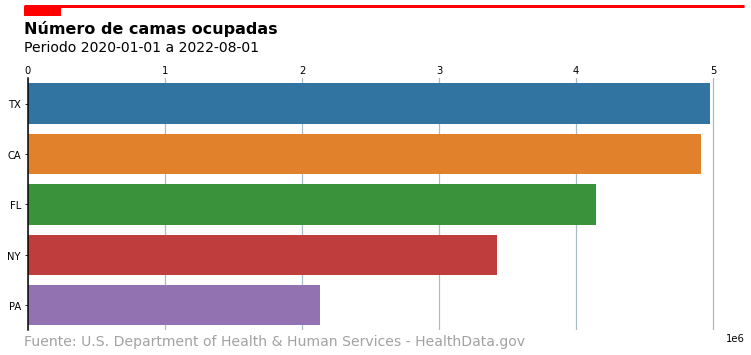

In [90]:
fig,ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='beds_covid', y=top_5.index, data=top_5)

ax.set_axisbelow(True)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)
ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)

plt.ylabel('')
plt.xlabel('')

fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)
fig.text(
    0, 0.925, "Número de camas ocupadas", 
    fontsize=16, fontweight="bold"
)
fig.text(
    0, 0.875, "Periodo 2020-01-01 a 2022-08-01", 
    fontsize=14
)
source = "Fuente: U.S. Department of Health & Human Services - HealthData.gov"
fig.text(
    0, 0.06, source, color="#a2a2a2", 
    fontsize=14, fontfamily="Econ Sans Cnd"
)
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='red', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='red'))

In [ ]:
#df = data_df[(data_df['date'] >= start_date_trans) & (data_df['date'] <= end_date_trans)]
df = data_df[['state', 'inpatient_beds_used_covid']].copy()
df_group = df.groupby('state').sum()
df_group.sort_values('inpatient_beds_used_covid', ascending=False, inplace=True)
camas = df_group.head(5).copy()
fig,ax = plt.subplots(figsize=(12, 7))
sns.barplot(x='inpatient_beds_used_covid', y=camas.index, data=camas)

ax.set_axisbelow(True)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)
ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)

plt.ylabel('')
plt.xlabel('')

fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)
fig.text(
    0, 0.925, "Número de camas ocupadas pacientes con COVID-19", 
    fontsize=16, fontweight="bold"
)
fig.text(
    0, 0.875, f"Periodo 2020-01-01 a 2022-08-01", 
    fontsize=14
)
source = "Sources: U.S. Department of Health & Human Services - HealthData.gov"
fig.text(
    0, 0.06, source, color="#a2a2a2", 
    fontsize=14, fontfamily="Econ Sans Cnd"
)
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color='red', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color='red'))